In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
first_measurement = session.query(Measurement).first()
first_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe5796f40d0>,
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'station': 'USC00519397'}

In [88]:
# Earliest date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [30]:
# Latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()._asdict()['date']

In [31]:
latest_date

'2017-08-23'

In [40]:
latest_date_dt = dt.datetime.strptime(latest_date, '%Y-%m-%d')

In [43]:
year_from_last = latest_date_dt - dt.timedelta(days=365)
year_from_last_string = year_from_last.strftime("%Y-%m-%d")
year_from_last_string

'2016-08-23'

# Exploratory Climate Analysis

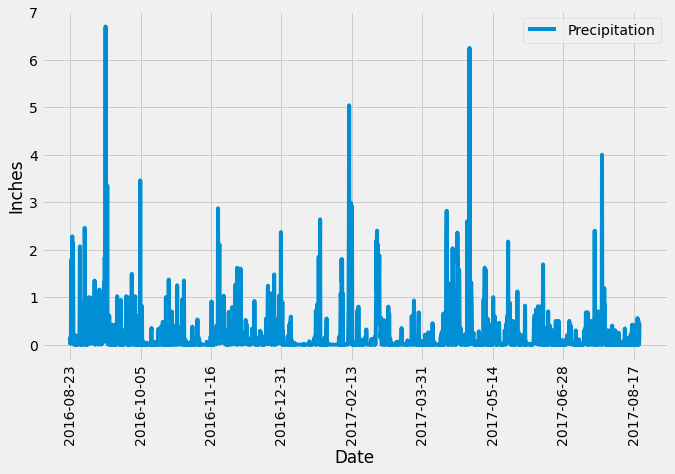

In [119]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the date and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_from_last_string).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data)
df.columns = ['Date', 'Precipitation']
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(ylabel='Inches',rot=90, figsize=(10,6))
plt.legend(loc='upper right')
plt.show()

In [116]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [92]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct

data = session.query(func.count(distinct(Measurement.station))).scalar()
data

9

In [97]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import text
data = session.query(Measurement.station, func.count(Measurement.station).label('total')).group_by(Measurement.station).order_by(text('total DESC')).all()
data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [105]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = data[0][0]
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f'Most active station:{most_active_station}\nLowest temp recorded: {lowest}\nHighest temp recorded: {highest}\nAverage temp recorded: {round(average, 2)}')


Most active station:USC00519281
Lowest temp recorded: 54.0
Highest temp recorded: 85.0
Average temp recorded: 71.66


array([[<AxesSubplot:title={'center':'tobs'}>]], dtype=object)

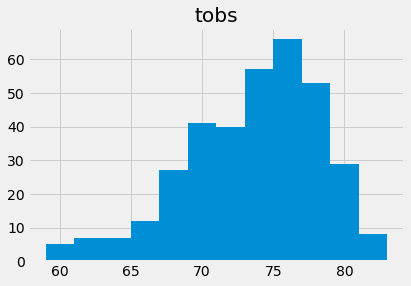

In [114]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_from_last_string, Measurement.station == most_active_station).\
    order_by(Measurement.date).all()
pd.DataFrame(data).hist(bins=12)

## Bonus Challenge Assignment

In [120]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
